Generate a synthetic dataset with 1000 records with various sensors and 25 machine failures. Distribute the failures at regular intervals. In addition, increase the sensor values progressively a few timestamps before the actual failure to insert a pattern that the model can learn.

In [14]:
import pandas as pd
import numpy as np
from datetime import timedelta

np.random.seed(42)

n_records = 1000
n_failures = 25
min_failure_lead_time = 10
max_failure_lead_time = 20

start_time = pd.Timestamp('2024-10-01 00:00:00')
timestamps = [start_time + timedelta(hours=i) for i in range(n_records)]

machine_ids = ['M001'] * n_records

temperature_normal = np.random.normal(70, 5, n_records).clip(60, 100)
pressure_normal = np.random.normal(3, 0.5, n_records).clip(2, 7)
vibration_normal = np.random.normal(0.5, 0.2, n_records).clip(0.1, 3)
runtime = np.arange(100, 100 + n_records)

temperature = temperature_normal.copy()
pressure = pressure_normal.copy()
vibration = vibration_normal.copy()
status = ['Normal'] * n_records

max_interval = (n_records - min_failure_lead_time) // n_failures

if max_interval <= 0:
    raise ValueError("Too many failures relative to the number of records.")

failure_indices = [i * max_interval + np.random.randint(0, max_interval) for i in range(n_failures)]
failure_indices = np.unique(failure_indices)

failure_indices = [idx for idx in failure_indices if idx < n_records and idx - min_failure_lead_time >= 0]

n_failures = len(failure_indices)

for idx in failure_indices:
    failure_lead_time = np.random.randint(min_failure_lead_time, max_failure_lead_time + 1)

    for i in range(idx - failure_lead_time, idx):
        temperature[i] = min(temperature[i] + np.random.uniform(10, 20), 100)
        pressure[i] = min(pressure[i] + np.random.uniform(1.0, 2.0), 7)
        vibration[i] = min(vibration[i] + np.random.uniform(0.5, 1.0), 3)

    status[idx] = 'Failure'

df = pd.DataFrame({
    'Timestamp': timestamps,
    'Machine ID': machine_ids,
    'Temperature (°C)': temperature,
    'Pressure (bar)': pressure,
    'Vibration (mm/s)': vibration,
    'Runtime (hours)': runtime,
    'Status': status
})

df


,Timestamp,Machine ID,Temperature (°C),Pressure (bar),Vibration (mm/s),Runtime (hours),Status
0,2024-10-01 00:00:00,M001,72.483571,3.699678,0.364964,100,Normal
1,2024-10-01 01:00:00,M001,69.308678,3.462317,0.471096,101,Normal
2,2024-10-01 02:00:00,M001,73.238443,3.029815,0.341516,102,Normal
3,2024-10-01 03:00:00,M001,77.615149,2.676532,0.438408,103,Normal
4,2024-10-01 04:00:00,M001,68.829233,3.349112,0.121277,104,Normal
...,...,...,...,...,...,...,...
995,2024-11-11 11:00:00,M001,68.594499,3.535075,0.515496,1095,Normal
996,2024-11-11 12:00:00,M001,78.988433,2.986739,0.551551,1096,Normal
997,2024-11-11 13:00:00,M001,73.204214,2.559063,0.251648,1097,Normal
998,2024-11-11 14:00:00,M001,67.144105,2.918467,0.566835,1098,Normal


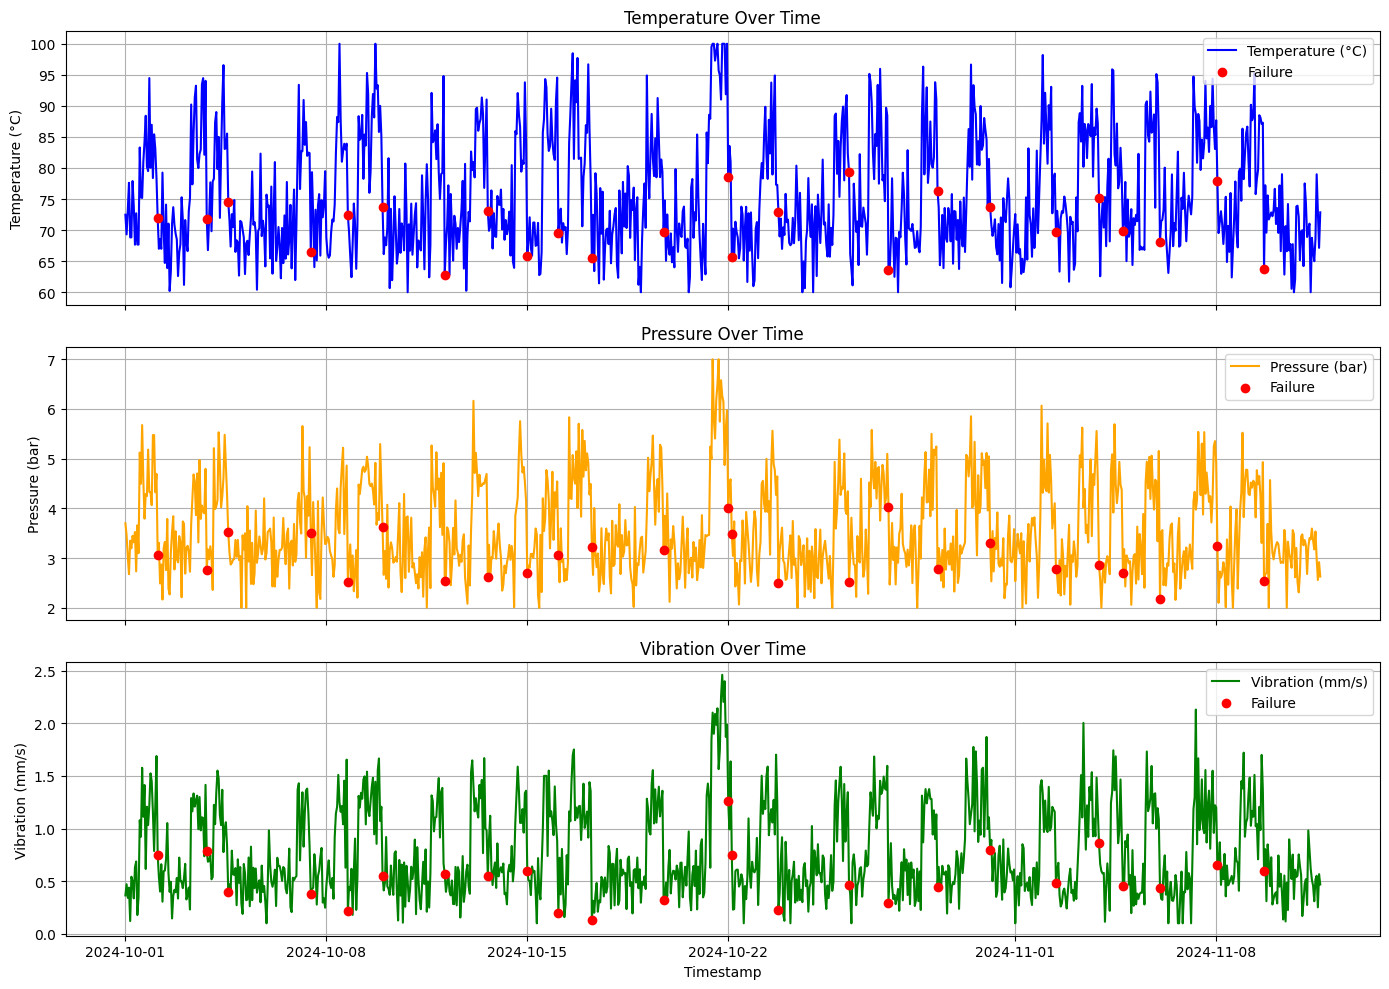

In [15]:
import matplotlib.pyplot as plt

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
failures = df[df['Status'] == 'Failure']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=True)

axes[0].plot(df['Timestamp'], df['Temperature (°C)'], label='Temperature (°C)', color='blue')
axes[0].scatter(failures['Timestamp'], failures['Temperature (°C)'], color='red', label='Failure', zorder=5)
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Temperature Over Time')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(df['Timestamp'], df['Pressure (bar)'], label='Pressure (bar)', color='orange')
axes[1].scatter(failures['Timestamp'], failures['Pressure (bar)'], color='red', label='Failure', zorder=5)
axes[1].set_ylabel('Pressure (bar)')
axes[1].set_title('Pressure Over Time')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(df['Timestamp'], df['Vibration (mm/s)'], label='Vibration (mm/s)', color='green')
axes[2].scatter(failures['Timestamp'], failures['Vibration (mm/s)'], color='red', label='Failure', zorder=5)
axes[2].set_ylabel('Vibration (mm/s)')
axes[2].set_title('Vibration Over Time')
axes[2].legend()
axes[2].grid(True)

plt.xlabel('Timestamp')
plt.tight_layout()
plt.show()


Use a standard random forest without any time series specific feature engineering. The accuracy is going to be great but super poor precision and recall.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

X = df[['Temperature (°C)', 'Pressure (bar)', 'Vibration (mm/s)', 'Runtime (hours)']]
y = df['Status'].apply(lambda x: 1 if x == 'Failure' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

Accuracy: 0.98, Precision: 0.00, Recall: 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Use SMOTE to oversample the failure cases to deal with the inherent class imbalance. This should improve the precision and recall.

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

X = df[['Temperature (°C)', 'Pressure (bar)', 'Vibration (mm/s)', 'Runtime (hours)']]
y = df['Status'].apply(lambda x: 1 if x == 'Failure' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_resampled, y_resampled)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

Accuracy: 0.91, Precision: 0.04, Recall: 0.17


Use a lag period of 3 to enable the model to capture temporal patterns. This should improve the precision and recall.

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

def create_lagged_features(df, lag_periods):
    for lag in range(1, lag_periods + 1):
        df[f'Temperature (°C) Lag {lag}'] = df['Temperature (°C)'].shift(lag)
        df[f'Pressure (bar) Lag {lag}'] = df['Pressure (bar)'].shift(lag)
        df[f'Vibration (mm/s) Lag {lag}'] = df['Vibration (mm/s)'].shift(lag)

    df_lagged = df.dropna().reset_index(drop=True)
    return df_lagged

def train_random_forest_with_smote_and_lags(df, target_column, feature_columns, lag_periods, test_size=0.3, random_state=42):
    df_lagged = create_lagged_features(df, lag_periods)

    X = df_lagged[feature_columns +
                  [f'Temperature (°C) Lag {lag}' for lag in range(1, lag_periods + 1)] +
                  [f'Pressure (bar) Lag {lag}' for lag in range(1, lag_periods + 1)] +
                  [f'Vibration (mm/s) Lag {lag}' for lag in range(1, lag_periods + 1)]]
    y = df_lagged[target_column].apply(lambda x: 1 if x == 'Failure' else 0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    clf = RandomForestClassifier(random_state=random_state)
    clf.fit(X_resampled, y_resampled)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

feature_columns = ['Temperature (°C)', 'Pressure (bar)', 'Vibration (mm/s)', 'Runtime (hours)']
target_column = 'Status'
lag_periods = 3

train_random_forest_with_smote_and_lags(df, target_column, feature_columns, lag_periods, test_size=0.3, random_state=42)


Accuracy: 0.99, Precision: 0.80, Recall: 0.67
